In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [3]:
# true_df=pd.read_csv("/content/drive/MyDrive/fake_news_dataset/true.csv")
true_df=pd.read_csv("cleaned - cleaned.csv")
fake_df=pd.read_csv("fake.csv")

In [4]:
true_df["Out"]=1 # 1 for True
fake_df['Out']=0 # 0 for False
df=pd.concat([true_df,fake_df]) # Join both datasets
df=df.sample(frac = 1) #shuffle
print(df.shape)
df.head()

(46827, 5)


,title,text,Out,subject,date
1499,"Trump Ignores Historically Low Rating, Brags ...",The fact that most of the country despises Don...,0,News,"May 12, 2017"
8353,Creepy: Christie Is The Latest Republican To ...,The Republican presidential candidates have be...,0,News,"February 3, 2016"
1572,Multiple Sclerosis Patient Montel Williams Ri...,"Montel Williams, who has been fighting Multipl...",0,News,"May 6, 2017"
1893,Nani 32: Actor announces next project after Sa...,The first details of Nani's next project Nani ...,1,NaN,NaN
2414,Angry Constituents Shame Republican By Turnin...,Republicans should be ashamed of themselves an...,0,News,"February 23, 2017"


In [5]:
df.drop(columns=['subject','date'],inplace=True)

<Axes: xlabel='Out'>

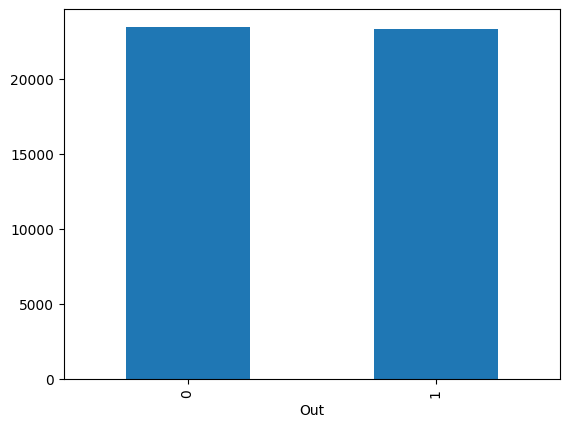

In [6]:
df.Out.value_counts().plot(kind="bar")

In [7]:
df.head()

,title,text,Out
1499,"Trump Ignores Historically Low Rating, Brags ...",The fact that most of the country despises Don...,0
8353,Creepy: Christie Is The Latest Republican To ...,The Republican presidential candidates have be...,0
1572,Multiple Sclerosis Patient Montel Williams Ri...,"Montel Williams, who has been fighting Multipl...",0
1893,Nani 32: Actor announces next project after Sa...,The first details of Nani's next project Nani ...,1
2414,Angry Constituents Shame Republican By Turnin...,Republicans should be ashamed of themselves an...,0


In [8]:
df.dropna(inplace=True,how='any')
df.reset_index(inplace=True,drop=True)
df.shape

(46797, 3)

In [9]:
import re  # Regular expressions
import nltk  # Natural language processing]
from nltk.corpus import stopwords  # Stopwords
nltk.download('stopwords')  # Download stopwords corpus
# Get the stopwords for the language.
stpwrds = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhi1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# General transformation in the text
def preprocessing(mc):

    mc = mc.replace("\n"," ").replace("\t"," ")
    mc = mc.lower()
    mc = re.sub('@[^\s]+', '', mc)
    mc = re.sub(r'\B#\S+', '', mc)
    mc = re.sub(r"http\S+", "", mc)
    mc = ' '.join(re.findall(r'\w+', mc))
    mc = re.sub(r'\s+[b-zA-Z]\s+', ' ', mc)
    mc = re.sub(r'\s+', ' ', mc, flags=re.I)


    return mc

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create CountVectorizer object
tdf_vectorizer = TfidfVectorizer(ngram_range=(1,3),stop_words='english',preprocessor=preprocessing,max_features=8000)

# Generate matrix of word vectors
tdf_vec = tdf_vectorizer.fit_transform(df['text'])

tdf_vec.shape

(46797, 8000)

In [12]:
y=df['Out']
df.drop(columns=['Out','text','title'],inplace=True)

In [13]:
# Creating final Data Frame
merged = pd.concat([df,pd.DataFrame(tdf_vec.toarray(), columns=tdf_vectorizer.get_feature_names_out())],axis=1)
merged['Out']=y
x=merged.drop('Out',axis=1)

In [14]:
del df,tdf_vec,true_df,fake_df,merged,stopwords,stpwrds,tdf_vectorizer #for freeing up RAM due to size of dataset

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((37437, 8000), (9360, 8000), (37437,), (9360,))

In [16]:
del x,y #for freeing up RAM due to size of dataset

In [17]:
from sklearn.metrics import accuracy_score,log_loss
from lightgbm import LGBMClassifier

lgr = LGBMClassifier()

lgr.fit(x_train,y_train)

y_pred = lgr.predict(x_test)
y_pred_prob = lgr.predict_proba(x_test)

score =accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred_prob)

print("Accuracy score of LGR model is ",score)
print("Log Loss of LGR model is ",loss)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18600, number of negative: 18837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.551626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1177874
[LightGBM] [Info] Number of data points in the train set: 37437, number of used features: 7833
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496835 -> initscore=-0.012661
[LightGBM] [Info] Start training from score -0.012661
Accuracy score of LGR model is  0.9989316239316239
Log Loss of LGR model is  0.0037131542302183016


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
lgr = XGBClassifier()

lgr.fit(x_train,y_train)

y_pred = lgr.predict(x_test)

score =accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred_prob)

print("Accuracy score of LGR model is ",score)
print("Log Loss of LGR model is ",loss)

Accuracy score of LGR model is  0.9988247863247863
Log Loss of LGR model is  0.0037131542302183016


In [19]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='newton-cg')

lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

score =accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred_prob)

print("Accuracy score of LGR model is ",score)
print("Log Loss of LGR model is ",loss)

Accuracy score of LGR model is  0.9967948717948718
Log Loss of LGR model is  0.0037131542302183016


In [20]:
from sklearn.linear_model import PassiveAggressiveClassifier
lr = PassiveAggressiveClassifier()

lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

score =accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred_prob)

print("Accuracy score of LGR model is ",score)
print("Log Loss of LGR model is ",loss)

Accuracy score of LGR model is  0.9988247863247863
Log Loss of LGR model is  0.0037131542302183016


In [21]:
from sklearn.naive_bayes import GaussianNB
lr = GaussianNB()

lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

score =accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred_prob)

print("Accuracy score of LGR model is ",score)
print("Log Loss of LGR model is ",loss)

Accuracy score of LGR model is  0.9972222222222222
Log Loss of LGR model is  0.0037131542302183016


In [22]:
from sklearn.tree import DecisionTreeClassifier
lr = DecisionTreeClassifier()

lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

score =accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred_prob)

print("Accuracy score of LGR model is ",score)
print("Log Loss of LGR model is ",loss)

Accuracy score of LGR model is  0.9976495726495727
Log Loss of LGR model is  0.0037131542302183016
